```
This software is part of GPU Ocean. 

Copyright (C) 2022 SINTEF Digital

Minimal example for testing if wind is correctly implemented

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Check the wind textures

In [7]:
#Lets have matplotlib "inline"
%matplotlib inline

from importlib import reload

#Import packages we need
import numpy as np
from netCDF4 import Dataset
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

In [8]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import WindStress, IPythonMagic, Common, PlotHelper


In [9]:
%cuda_context_handler gpu_ctx

In [10]:
def sim_animation(sim, T, anim_dt, hu_max=2.0, eta_max=0.5):
    """
    Creates an animation of the simulator based on T frames, with frames sub_dt*sim.dt appart.
    """
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(15, 4))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='lower', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    plt.title('eta')
    fig.colorbar(sp_eta)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hu')
    fig.colorbar(sp_u)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hv')
    fig.colorbar(sp_v)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(anim_dt)
        else:
            t = 0.0
        eta1, u1, v1 = sim.download(interior_domain_only=True)

        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)

        fig.sca(ax_u)
        sp_u.set_data(u1)

        fig.sca(ax_v)
        sp_v.set_data(v1)

        fig.suptitle("Time = {:04.0f} h ({:s})".format(t/3600, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

## Define simulator
Make a simple domain that is periodic in x and with lake-at-rest initial conditions 

In [11]:
sim_args_x = {
    "gpu_ctx": gpu_ctx,
    "nx": 500, "ny": 400, "dx": 800, "dy": 500,
    "g": 9.81, "dt": 0.0, "f": 0.0, "r": 0.0,
    "boundary_conditions": Common.BoundaryConditions(north=1, south=1,
                                                     east =2, west =2)
}

dataShape = (sim_args_x["ny"]+4, sim_args_x["nx"]+4)

init_args = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0" : np.zeros(dataShape, dtype=np.float32),
    "hv0" : np.zeros(dataShape, dtype=np.float32),
    "H"  : np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*100
}

## Define wind
 Make wind stress which is constant along x and gradually and linearly increases along y.
 This should give a linear velocity profile for $hu$ along y.


In [12]:
reload(WindStress)

def wind_linear_y():
    t = [0, 10*3600]
    u_wind = [np.zeros((2,1),     dtype=np.float32, order='C'),
              np.array([[10], [0]], dtype=np.float32, order='C')]
    v_wind = [np.zeros((1,1),     dtype=np.float32, order='C'),
              np.zeros((1,1),     dtype=np.float32, order='C')]
    
    return WindStress.WindStress(t=t, u_wind=u_wind, v_wind=v_wind)
ws_x = wind_linear_y()

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "c:\Users\havardh\Miniconda3\envs\gpuocean-extra\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\havardh\AppData\Local\Temp\ipykernel_14528\131826342.py", line 11, in <module>
    ws_x = wind_linear_y()
  File "C:\Users\havardh\AppData\Local\Temp\ipykernel_14528\131826342.py", line 10, in wind_linear_y
    return WindStress.WindStress(t=t, u_wind=u_wind, v_wind=v_wind)
TypeError: __init__() got an unexpected keyword argument 'u_wind'


TypeError: __init__() got an unexpected keyword argument 'u_wind'

In [ ]:
reload(WindStress)

def wind_linear_y_long():
    t = [0, 10*360]
    u_wind = [np.zeros((sim_args_x["ny"]+4,1), dtype=np.float32, order='C'),
              np.zeros((sim_args_x["ny"]+4,1), dtype=np.float32, order='C')]
    v_wind = [np.zeros((1,1),     dtype=np.float32, order='C'),
              np.zeros((1,1),     dtype=np.float32, order='C')]
    
    #u_wind[1][:,0] += np.linspace(0, 10, sim_args_x["ny"])
    u_wind[1][:,0] += np.linspace(0, 5e-4, sim_args_x["ny"]+4)

    return WindStress.WindStress(t=t, X=u_wind, Y=v_wind)
ws_x_long = wind_linear_y_long()
#print(ws_x_long.X[1])

In [ ]:
if 'sim' in globals():
    sim.cleanUp()

reload(CDKLM16)

sim = CDKLM16.CDKLM16(**sim_args_x, **init_args, wind_stress=wind_linear_y_long())
sim_animation(sim, 24, 360)


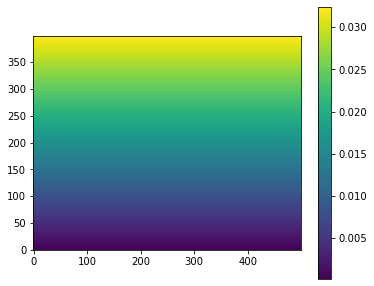

In [ ]:
fig = plt.figure(figsize=(6,5))
eta, hu, hv = sim.download(interior_domain_only=True)
plt.imshow(hu/100, origin="lower")
plt.colorbar()

# Investigate in the cross section on y
We see (before bug fix) that the northernmost values for $hu$ are no longer linearly increasing, but constant.

This is because the texture fetch for the wind stress was given as 
$j/N_y$, where $j$ was cell index globally (including ghost cells) plus 0.5 to account for being in the middle of the cell. Meaning that the the final two grid cells in the interior domain would fetch outside of the texture, resulting in a constant value (due to LINEAR texture flag, as table lookup is not available).

This behaviour is expected though, if the texture is smaller than the number of grid cells, but since the NetCDFInitializer reads wind data onto the same discretized domain as the rest of the model - including ghost cells - we should not see this behavior.

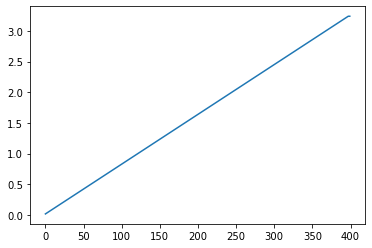

In [ ]:
plt.plot(hu[:, 100])

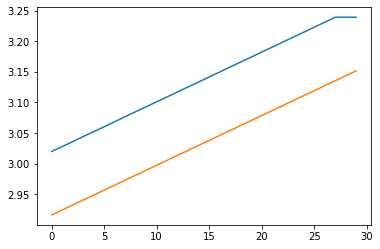

In [ ]:
plt.plot(hu[370:, 100])
plt.plot(hu[:30,  100]+2.9)

In [ ]:
for j in range(1, sim.ny):
    if hu[j-1, 100] >= hu[j, 100]:
        print("buuuu", j)


buuuu 399
